<a href="https://colab.research.google.com/github/RISHAD-prog/Human_Activity_Recognition_UCF101/blob/main/HAR_UCF101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install remotezip tqdm opencv-python einops
# Install TensorFlow 2.10
!pip install tensorflow==2.10.0

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.3 MB/s eta 0:00:00
  Created wheel for remotezip: filename=remotezip-0.12.1-py3-none-any.whl size=7933 sha256=8dc9ebb9b6acfdc1bfc4131ead5cbcb58dab084030d875fabc5536f6454da2c8
  Stored in directory: /root/.cache/pip/wheels/fc/76/04/beed1a6df4eb7430ee13c3900746edd517e5e597298d1f73f3
Successfully built remotezip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

In [3]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

In [4]:
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped.

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [5]:
def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

In [6]:
def download_from_zip(zip_url, to_dir, file_names):

  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = fn.split('_')[-3]
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

In [7]:
def split_class_lists(files_for_class, count):

  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

In [8]:
def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [9]:
def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

In [10]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL,
                        num_classes = 10,
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


100%|██████████| 300/300 [01:10<00:00,  4.25it/s]


val :


100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


test :


100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


In [11]:
download_dir = pathlib.Path('/content/UCF101_subset/')
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


In [12]:
!find /content/drive/MyDrive/Thesis/UCF101_subset

find: ‘/content/drive/MyDrive/Thesis/UCF101_subset’: No such file or directory


In [13]:
def format_frame(frame, output_size):
 frame = tf.image.convert_image_dtype(frame, tf.float32)
 frame = tf.image.resize_with_pad(frame, *output_size)
 return frame

In [14]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):

  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frame(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frame(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [15]:
def generate_frames(path, n_frames, training=False):
    class_names = sorted(set(p.name for p in path.iterdir() if p.is_dir()))
    class_ids_for_name = dict((name, idx) for idx, name in enumerate(class_names))

    def get_files_and_class_names():
        video_paths = list(path.glob('*/*.avi'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    video_paths, classes = get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if training:
        random.shuffle(pairs)

    for path, name in pairs:
        video_frames = frames_from_video_file(path, n_frames)
        label = class_ids_for_name[name]  # Encode labels
        yield video_frames, label

In [16]:
def add_data_noise(frame):
    # Add Gaussian noise to the frame
    noise = tf.random.normal(shape=tf.shape(frame), mean=0.0, stddev=0.1)
    noisy_frame = frame + noise
    return noisy_frame

In [17]:
import tensorflow as tf

# Define your data augmentation transformations using TensorFlow
def apply_data_augmentation(frames, label):
    # Create a tensor array to collect augmented frames
    augmented_frames = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)

    # Loop over frames and apply augmentation
    for frame in frames:
        augmented_frame = apply_augmentation(frame)
        noisy_frame = add_data_noise(augmented_frame)  # Add Gaussian noise to the frame
        augmented_frames = augmented_frames.write(augmented_frames.size(), noisy_frame)

    # Stack the augmented frames using tf.stack
    augmented_frames_tensor = augmented_frames.stack()

    # Manually calculate mean and std deviation for standardization
    mean, variance = tf.nn.moments(augmented_frames_tensor, axes=[0, 1, 2], keepdims=True)
    normalized_frames = (augmented_frames_tensor - mean) / tf.sqrt(variance + 1e-6)

    return normalized_frames, label

def apply_augmentation(frame):
    # Resize the frame
    resized_frame = tf.image.resize(frame, (224, 224))

    # Randomly flip horizontally
    horizontally_flipped_frame = tf.image.random_flip_left_right(resized_frame)

    # Adjust color using brightness, contrast, saturation, and hue adjustments
    adjusted_frame = tf.image.random_brightness(horizontally_flipped_frame, max_delta=0.2)
    adjusted_frame = tf.image.random_contrast(adjusted_frame, lower=0.8, upper=1.2)
    adjusted_frame = tf.image.random_saturation(adjusted_frame, lower=0.8, upper=1.2)
    adjusted_frame = tf.image.random_hue(adjusted_frame, max_delta=0.1)

    # Apply random rotation within [-10, 10] degrees
    rotation_angle = tf.random.uniform(shape=(), minval=-10, maxval=10)
    rotation_angle_radians = rotation_angle * (3.141592653589793 / 180.0)

    # Apply rotation using tf.image.rot90
    rotated_frame = tf.image.rot90(adjusted_frame, k=tf.cast(rotation_angle // 90, tf.int32))  # Rotate in 90-degree increments

    # Randomly flip vertically
    vertically_flipped_frame = tf.image.random_flip_up_down(rotated_frame)

    return vertically_flipped_frame

# Rest of your code...
# Same as before...


In [53]:
n_frames = 10
batch_size = 8
AUTOTUNE = tf.data.AUTOTUNE

output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

# Training dataset
train_ds = tf.data.Dataset.from_generator(
    lambda: generate_frames(subset_paths['train'], n_frames, training=True),
    output_signature=output_signature)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
train_ds = train_ds.batch(batch_size)

# Validation dataset
val_ds = tf.data.Dataset.from_generator(
    lambda: generate_frames(subset_paths['val'], n_frames),
    output_signature=output_signature)

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.batch(batch_size)

# Test dataset
test_ds = tf.data.Dataset.from_generator(
    lambda: generate_frames(subset_paths['test'], n_frames),
    output_signature=output_signature)

test_ds = test_ds.batch(batch_size)


In [48]:
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (8, 10, 224, 224, 3)
Shape of training labels: (8,)
Shape of validation set of frames: (8, 10, 224, 224, 3)
Shape of validation labels: (8,)


In [54]:
HEIGHT = 224
WIDTH = 224

In [50]:
from tensorflow.keras.layers import Conv2D, Conv3D, LayerNormalization, ReLU

def Conv2Plus1D(inputs, filters, kernel_size, padding):
    spatial_conv = Conv3D(filters=filters, kernel_size=(1, kernel_size[0], kernel_size[1]), padding=padding)(inputs)
    temporal_conv = Conv3D(filters=filters, kernel_size=(kernel_size[2], 1, 1), padding=padding)(spatial_conv)
    return temporal_conv

In [51]:
def ResidualMain(inputs, filters, kernel_size):
    conv2plus1d_1 = Conv2Plus1D(inputs, filters, kernel_size, padding='same')
    norm_1 = LayerNormalization()(conv2plus1d_1)
    relu_1 = ReLU()(norm_1)

    conv2plus1d_2 = Conv2Plus1D(relu_1, filters, kernel_size, padding='same')
    norm_2 = LayerNormalization()(conv2plus1d_2)

    return norm_2

In [23]:
from tensorflow.keras.layers import Dense, LayerNormalization

def Project(inputs, units):
    dense = Dense(units)(inputs)
    norm = LayerNormalization()(dense)
    return norm

In [24]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(input,filters,
                     kernel_size)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(res,out.shape[-1])

  return layers.add([res, out])

In [25]:
import einops
from tensorflow.keras import layers, Model

def ResizeVideo(video, height, width):
    # Assume the input 'video' has shape (batch_size, num_frames, original_height, original_width, channels)
    resized = layers.UpSampling3D(size=(1, height, width))(x)
    # Reshape the video tensor to work with Resizing layer
    reshaped_video = einops.rearrange(video, 'b t h w c -> (b t) h w c')

    # Create a Resizing layer
    resizing_layer = layers.Resizing(height, width)

    # Apply resizing to the images in the video
    resized_images = resizing_layer(reshaped_video)

    # Restore the original video shape
    resized_video = einops.rearrange(resized_images, '(b t) h w c -> b t h w c', t=video.shape[1])

    return resized_video


In [55]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)

# Input layer
input_layer = layers.Input(shape=input_shape[1:])
x = input_layer


# Initial Conv2Plus1D layer
x = Conv2Plus1D(x,filters=16, kernel_size=(3, 7, 7), padding='same')
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(x, HEIGHT // 2, WIDTH // 2)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(x, HEIGHT // 4, WIDTH // 4)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(x, HEIGHT // 8, WIDTH // 8)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(x, HEIGHT // 16, WIDTH // 16)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

# Global Average Pooling and Dense layers

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

# Create the model
model = Model(inputs=input_layer, outputs=x)

In [56]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [57]:
frames, label = next(iter(train_ds))
model.build(frames)

In [58]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [59]:
history = model.fit(x = train_ds,
                    epochs = 40,
                    validation_data = val_ds,
                    callbacks=[early_stopping] )

Epoch 1/40
38/38 [==============================] - 49s 1s/step - loss: 2.4701 - accuracy: 0.1467 - val_loss: 2.2583 - val_accuracy: 0.2200
Epoch 2/40
38/38 [==============================] - 26s 681ms/step - loss: 2.1807 - accuracy: 0.2367 - val_loss: 2.2101 - val_accuracy: 0.1700
Epoch 3/40
38/38 [==============================] - 27s 700ms/step - loss: 2.1297 - accuracy: 0.2433 - val_loss: 2.1441 - val_accuracy: 0.2300
Epoch 4/40
38/38 [==============================] - 26s 679ms/step - loss: 2.0241 - accuracy: 0.2400 - val_loss: 2.0115 - val_accuracy: 0.2700
Epoch 5/40
38/38 [==============================] - 26s 685ms/step - loss: 1.9323 - accuracy: 0.2800 - val_loss: 2.2451 - val_accuracy: 0.2400
Epoch 6/40
38/38 [==============================] - 26s 684ms/step - loss: 1.9027 - accuracy: 0.3167 - val_loss: 2.0305 - val_accuracy: 0.3300
Epoch 7/40
38/38 [==============================] - 26s 687ms/step - loss: 1.7711 - accuracy: 0.3700 - val_loss: 1.9204 - val_accuracy: 0.3000
Ep

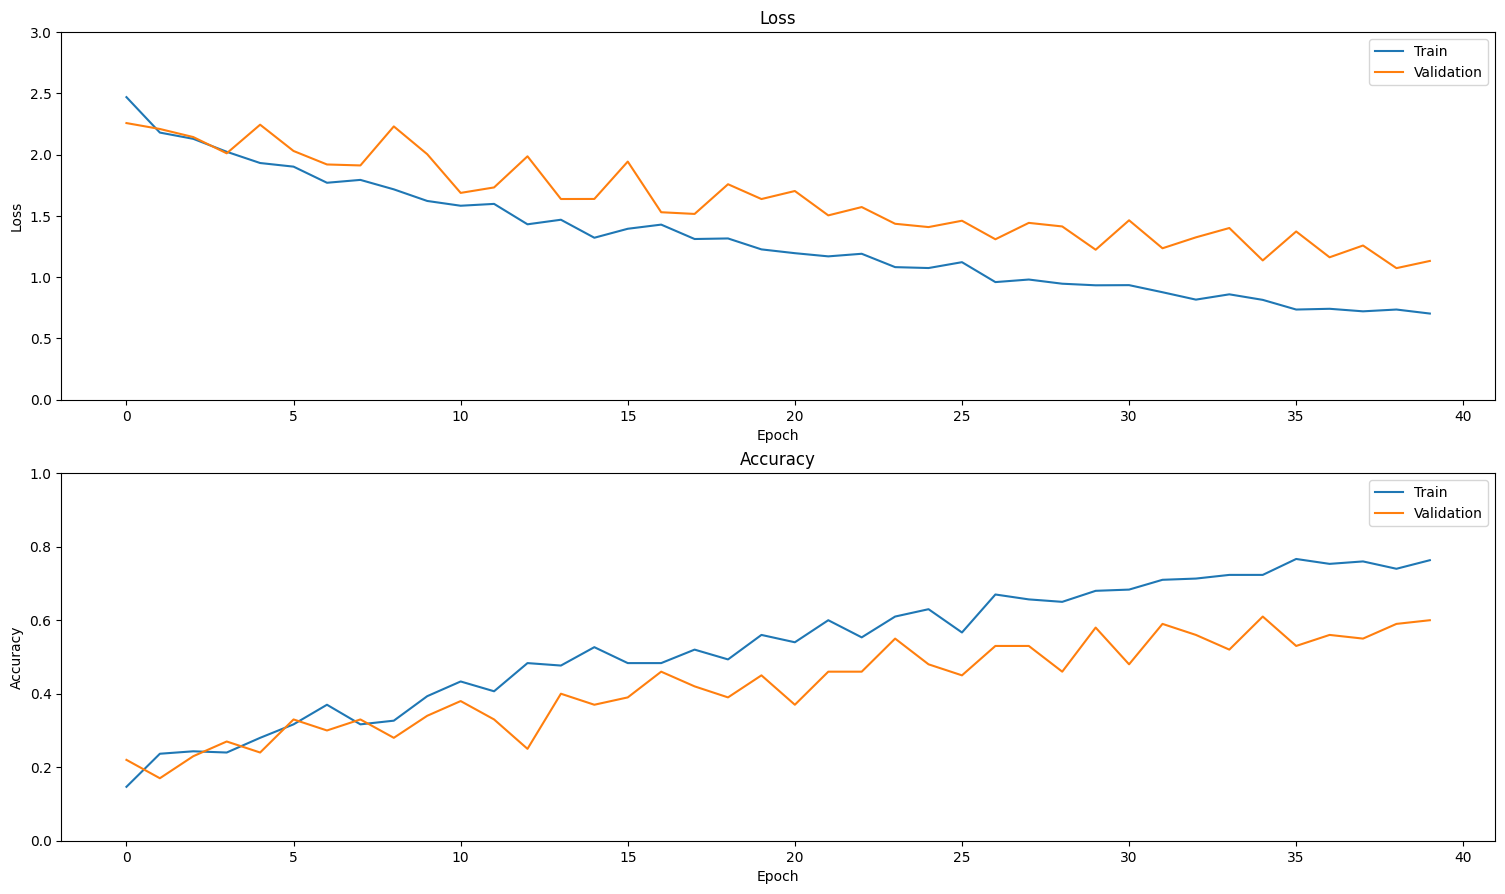

In [60]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [61]:
model.evaluate(test_ds, return_dict=True)

13/13 [==============================] - 14s 1s/step - loss: 0.9540 - accuracy: 0.6400


{'loss': 0.9539720416069031, 'accuracy': 0.6399999856948853}